In [14]:
import pymysql
import pandas.io.sql as psql

import pandas as pd
import numpy as np

import pickle
import pprint as pp

from sklearn.preprocessing import Imputer

from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.lda import LDA
from sklearn.qda import QDA

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
"""connect to TestStress"""
"""REMOVE account identifying information"""


def connect():
    """Function to connect to the database"""

    db = pymysql.connect(host=host,
                         user=user,
                         passwd=passwd,
                         db='stress_test')
    return db


def import_df(sql_table):
    """Import dataframe from MySql, returns a pandas dataframe"""

    db = connect()
    sql = "SELECT * FROM %s" % sql_table
    df = psql.read_sql(sql, db)
    db.close()

    return df

def gender(sex):
    if sex:
        return 'male'
    else:
        return 'female'

def result(diagnosis):
    if not diagnosis:
        return 'good'
    else:
        return 'bad'
    
def fill_holes(dataframe, catagorical, continuous, stratagey ='mean'):
   """takes a data frame where the missing values are nans a list of the columns that are catagorical
   and a list of the columns that continuous variables. relplaces the holes in the continuous
   variables either the mean or the median and replaces the catagorical variables with the mode"""
   imean = Imputer(copy=False, axis=1)
   imode = Imputer(strategy='most_frequent', copy=False, axis=1)
   imedian =Imputer(strategy='median', copy=False, axis=1)
   if stratagey == 'mean':
       continuous_imputer = imean
   else:
       continuous_imputer =  imedian
   catagorical_imputer = imode
   
   for col in catagorical:
       catagorical_imputer.fit_transform(dataframe[col])
   for col in continuous:
       continuous_imputer.fit_transform(dataframe[col])

def clean_data(df, categorical_list, continuous_list, drop=False):
    """ replaces '?' with NaN, formats numerical columns as floats, & replaces NaNs"""
    # replace empty fields with NaN
    df = df.replace('?', np.nan)
    
    col_to_float = df.columns[0:-2]
    # format columns
    df[col_to_float] = df[col_to_float].astype(float)
    df['chol_mg_dl'] = df['chol_mg_dl'].replace(0, np.nan)
    df['rest_bp'] = df['rest_bp'].replace(0, np.nan)
    df['gender'] = df['sex'].apply(lambda x: gender(x))
    df['result'] = df['diagnosis'].apply(lambda x: result(x))

    
    #### FUTURE: 
    
    # replace NaN
    if drop:
        df = df.dropna()
#         print 'slope', df.st_exercise_slope.value_counts()
#         print 'depression', df.st_depression.value_counts()
    else:
        fill_holes(df, categorical_list, continuous_list)
    
    return df

def add_dummies(df, categorical_list, additional_cat=None):
    """ Adds dummies for catergorical features"""
    for col in categorical_list:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    if additional_cat:
        df = pd.concat([df, pd.get_dummies(df[additional_cat], prefix=additional_cat)], axis=1)
        
    
    return df


if __name__ == '__main__':

    categorical_list = ['sex', 'chest_pain_type', 'fast_blood_sugar', 'rest_ecg', 'st_exercise_angina',
                        'st_exercise_slope', 'thal_defect']
    continuous_list = ['age', 'rest_bp', 'chol_mg_dl', 'st_max_heart_rt_ach', 'st_depression', 
                       'colored_vessels']
    
    drop_na_df = clean_data(import_df('all_hospitals'),
                            categorical_list,
                            continuous_list,
                            drop=True)
    df = add_dummies(clean_data(import_df('all_hospitals'), 
                                categorical_list, 
                                continuous_list),
                     categorical_list,
                     additional_cat='hospital')

    print 'Type of the dataframe', type(df)
    print 'Length of the dataframe:', len(df)
    print 'Length of the dropna dataframe:', len(drop_na_df)



Type of the dataframe <class 'pandas.core.frame.DataFrame'>
Length of the dataframe: 920
Length of the dropna dataframe: 299


In [8]:
df.head()

# df columns by INDEX

# CONTINUOS:
    # [0] age
    # [3] rest_bp (mm Hg on admission to hospital)
    # [4] chol_mg_dl
    # [7] st_max_heart_rt_ach
    # [9] st_depression (induced by exercise relative to rest)
    # [11] colored_vessels (0 - 3; colored by flouroscopy)
    
# CATEGORICAL:
    # [1] sex (1 = male, 0 = female)
    # [2] chest_pain_type (angina: 1 = typical, 2 = atypical, 3 = non-anginal, 4 = asymptomatic)
    # [5] fast_blood_sugar (> 120 mg/dl: 1 = True, 0 = False)
    # [6] rest_ecg (0 = normal, 1 = ST-T wave abnormality, 2 = probable or definite left ventrical hypertrophy)
    # [8] st_exercise_angina (1 = yes, 0 = no)
    # [10] st_exercise_slope (1 = unsloping, 2 = flat, 3 = downsloping)
    # [12] (stress test) thal_defect (thallium test: 3 = normal, 6 = fixed defect; 7 reversible defect)
    # [13] diagnosis (0 = < 50% diameter narrowing, 1 or higher = > 50% diameter narrowing)
    # [14] hospital
    # [15] patient_id (PRIMARY KEY)

,age,sex,chest_pain_type,rest_bp,chol_mg_dl,fast_blood_sugar,rest_ecg,st_max_heart_rt_ach,st_exercise_angina,st_depression,...,st_exercise_slope_1.0,st_exercise_slope_2.0,st_exercise_slope_3.0,thal_defect_3.0,thal_defect_6.0,thal_defect_7.0,hospital_cleveland,hospital_hungarian,hospital_switzerland,hospital_va
0,63,1,1,145,233,1,2,150,0,2.3,...,0,0,1,0,1,0,1,0,0,0
1,67,1,4,160,286,0,2,108,1,1.5,...,0,1,0,1,0,0,1,0,0,0
2,67,1,4,120,229,0,2,129,1,2.6,...,0,1,0,0,0,1,1,0,0,0
3,37,1,3,130,250,0,0,187,0,3.5,...,0,0,1,1,0,0,1,0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,...,1,0,0,1,0,0,1,0,0,0


In [9]:
test_df = df
test_dropna_df = drop_na_df

In [10]:
diagnosis_counts = test_df.diagnosis.value_counts()
sex_count = test_df.sex.where(test_df.hospital == 'cleveland').value_counts()

1    206
0     97
dtype: int64


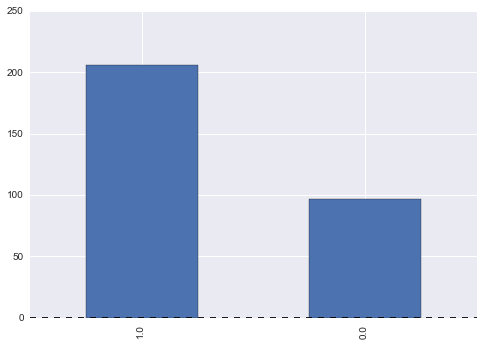

In [11]:
# diagnosis_counts.plot(kind='bar')

# ALL heavily skewed to represent MEN
print sex_count
sex_count.plot(kind='bar')

## Exploring Continuous Variables & Gender

Looking at Gender & Max Heart Rate Achieved in Stress Test, there appears to be a relationship suggesting that Stress Test data may be less informative for women than men. Assuming values to the left, including the peak, of distribution indicates poor heart health, then it appears more women can achieve higher heart rate during stress test despite general heart health.

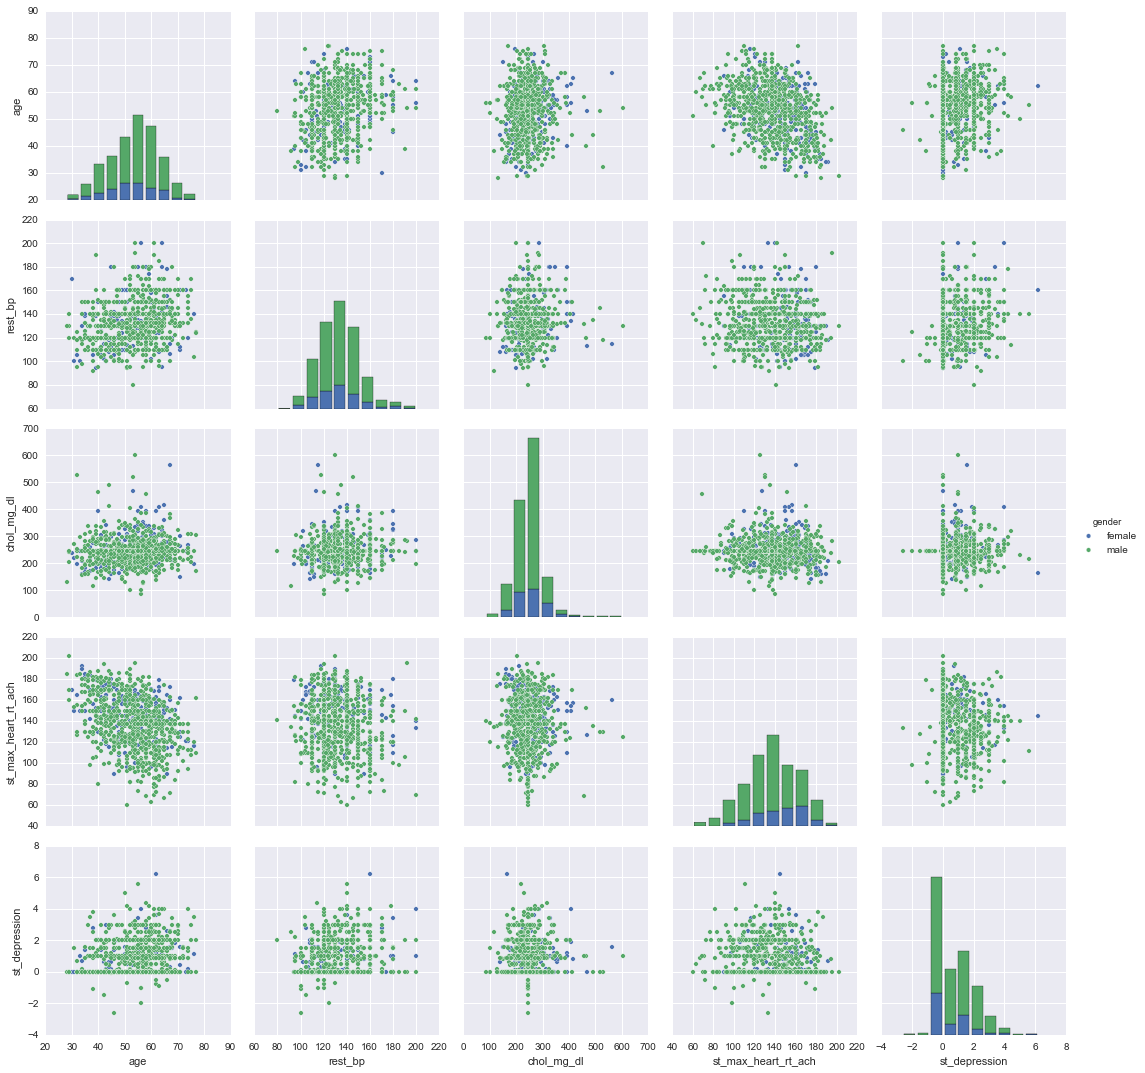

In [13]:
sns.pairplot(pd.concat([test_df[continuous_list[:-1]], test_df['gender']], axis=1), hue='gender')
# sns.pairplot(pd.concat([test_dropna_df[categorical_list], test_dropna_df['result']], axis=1), dropna=True, hue='result')

## Exploring Catergorical Variables & Gender

Looking at Gender & chest_pain_type you can see there is a relationship between gender and asymptomatic chest pain. 
Appears that less women with asymptomatic chest pain (i.e., majority of population presents heart disease this way) ending up in cardiologist offices.

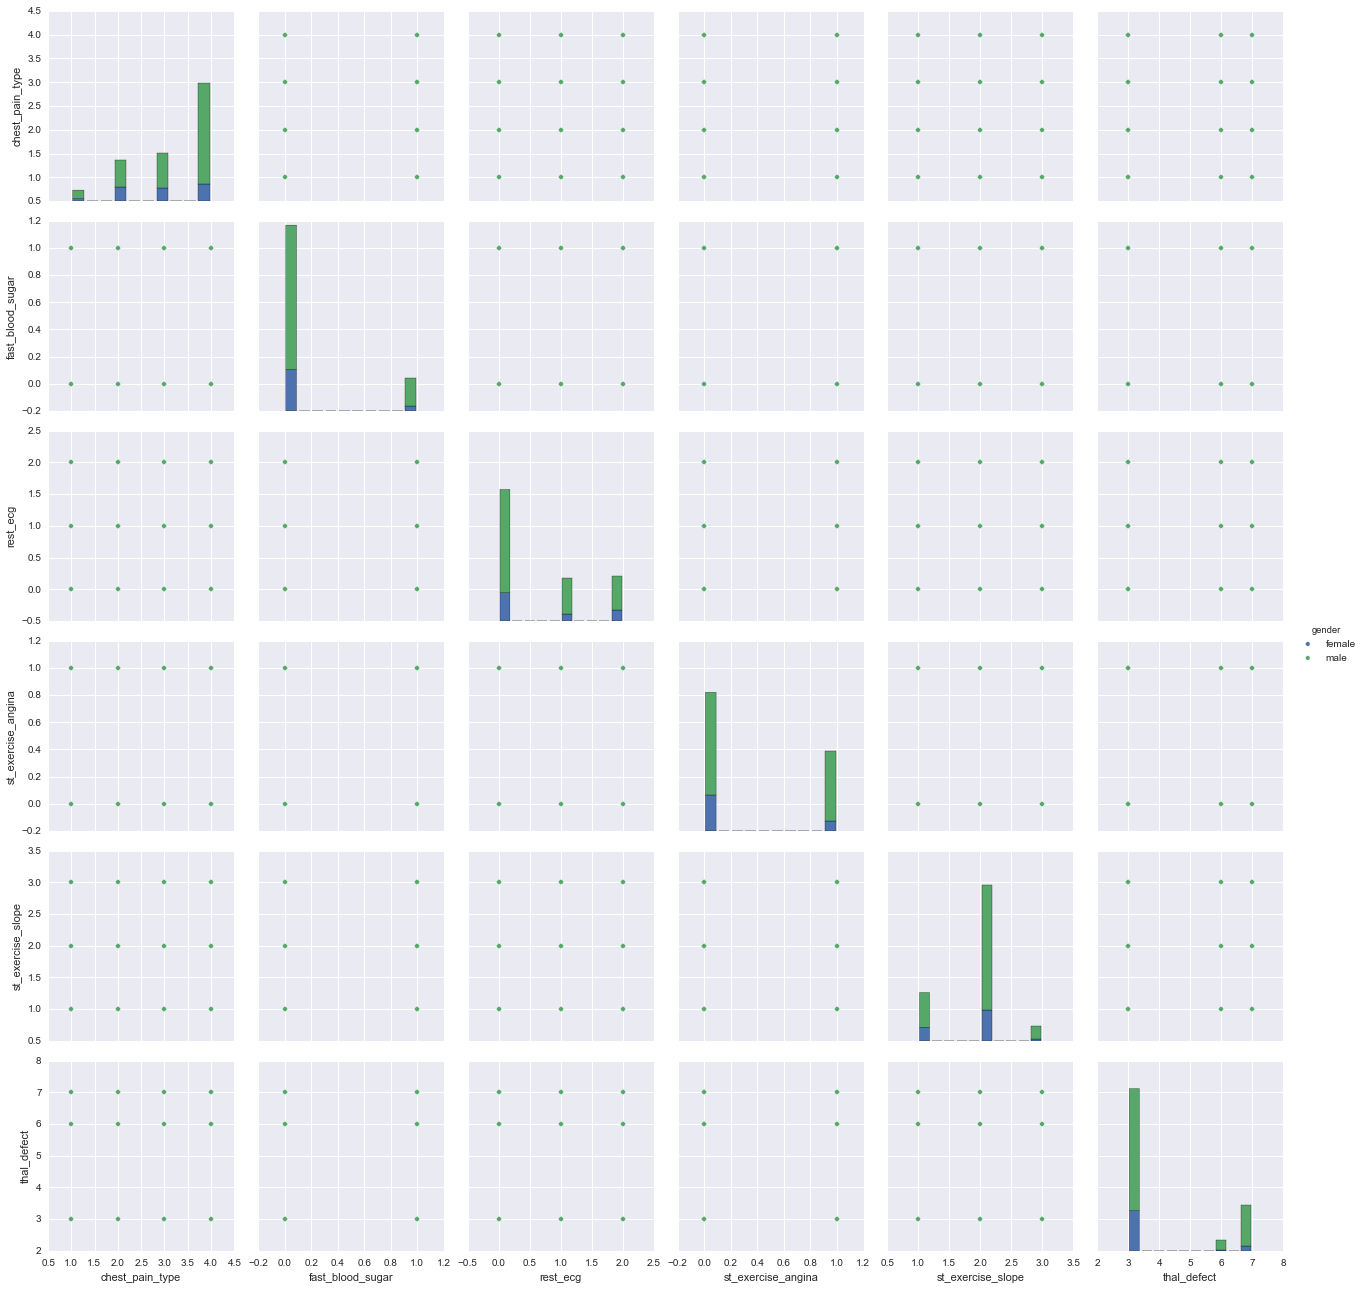

In [162]:
sns.pairplot(pd.concat([test_df[categorical_list[1:]], test_df['gender']], axis=1), hue='gender')

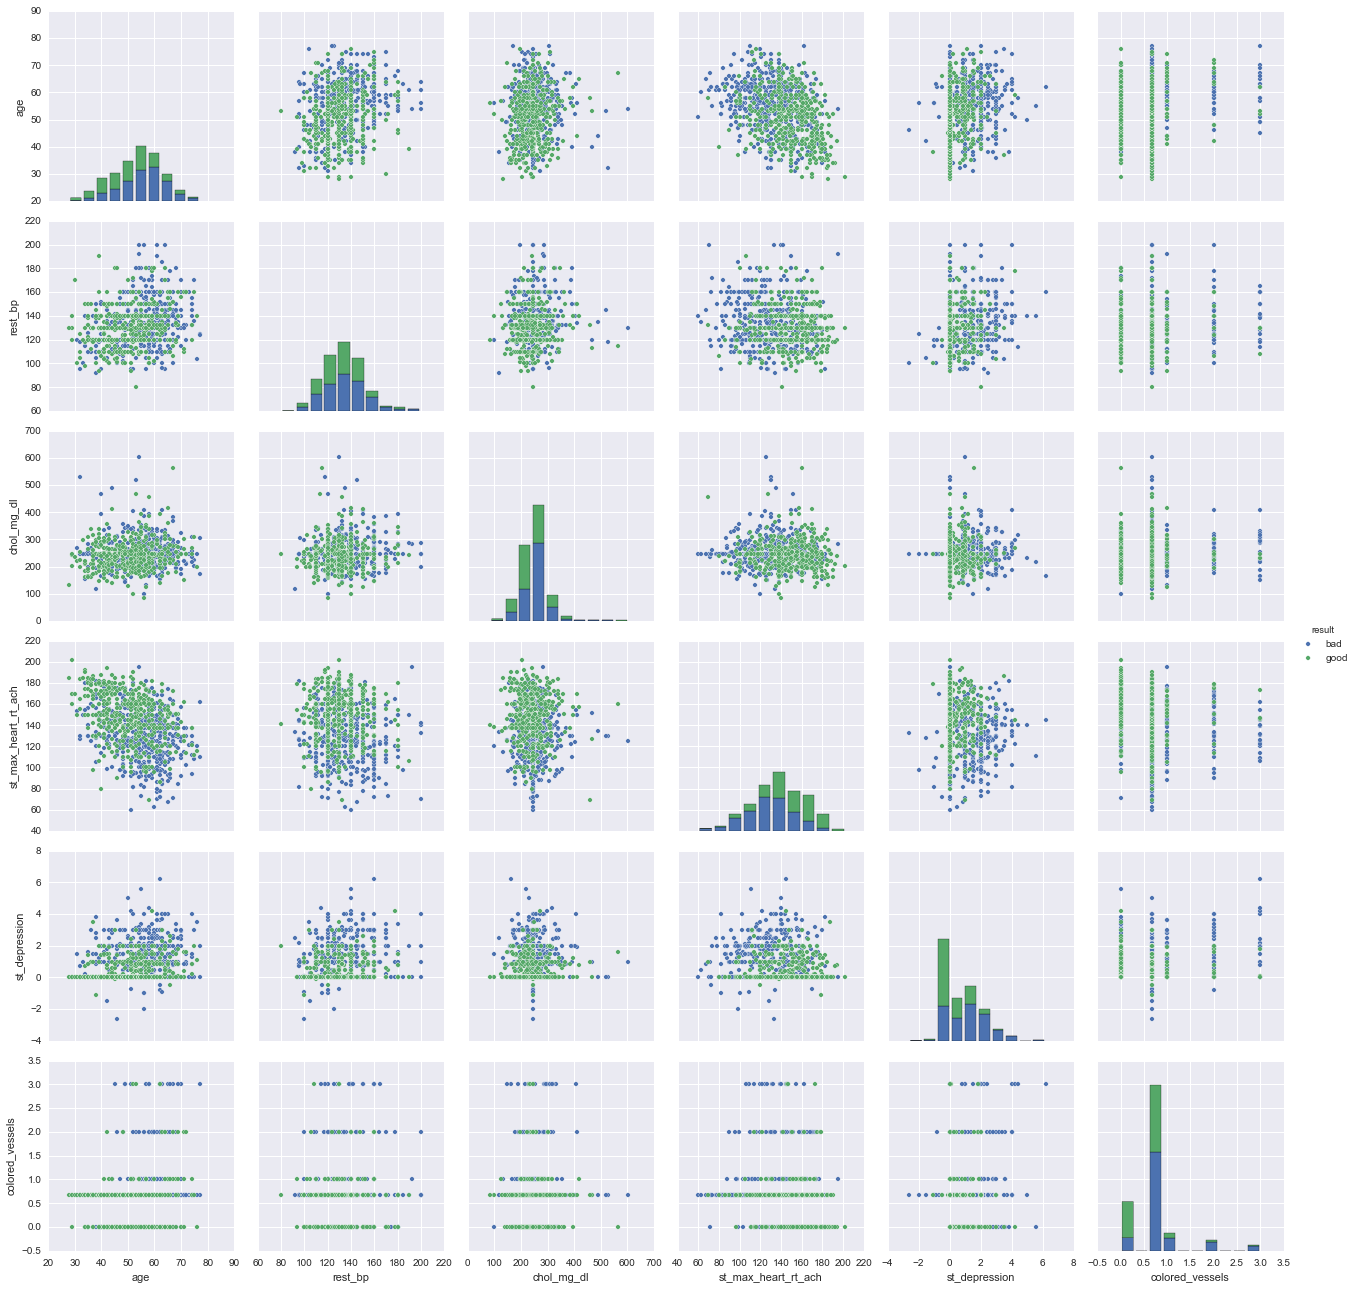

In [164]:
sns.pairplot(pd.concat([test_df[continuous_list], test_df['result']], axis=1), hue='result')

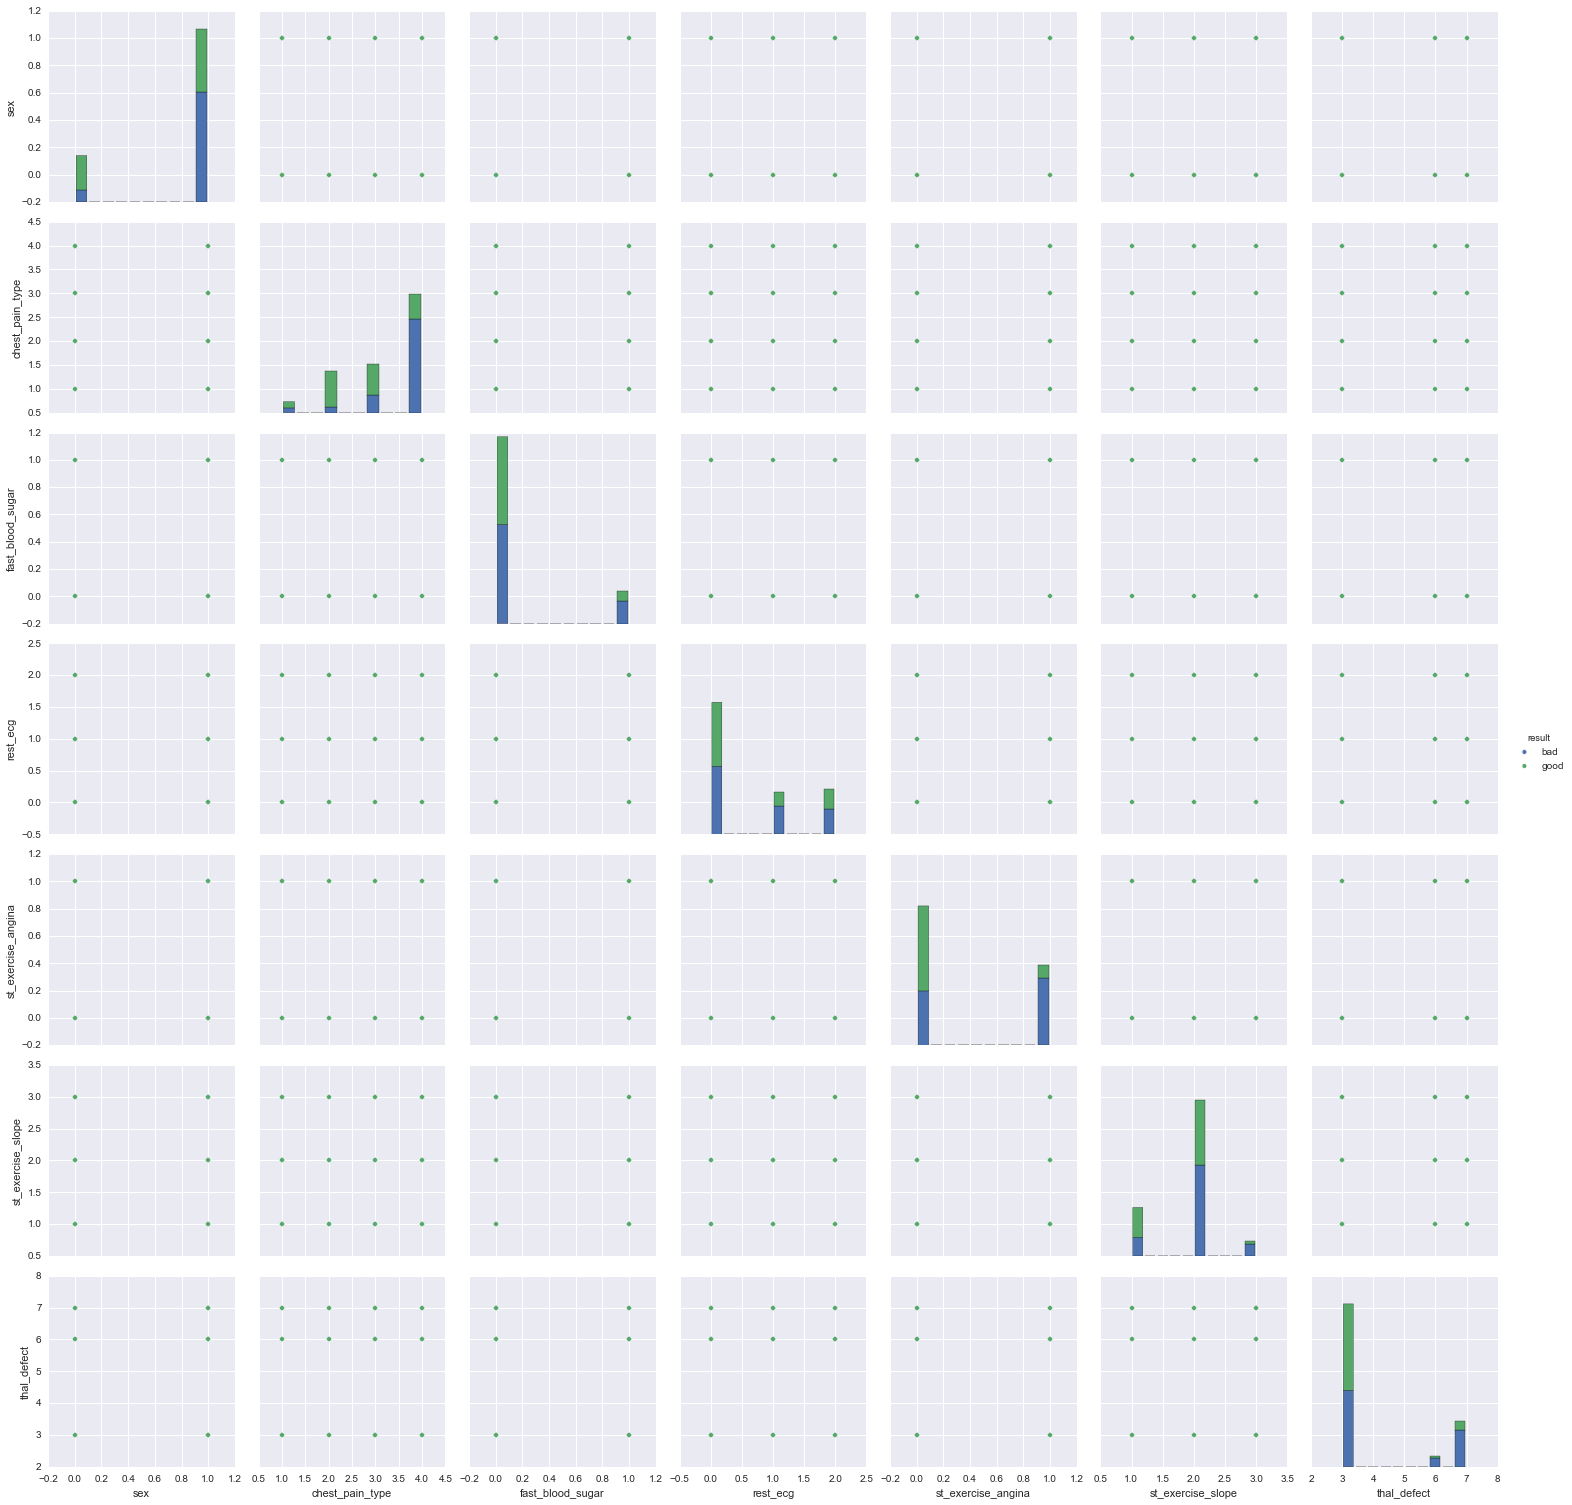

In [18]:
sns.pairplot(pd.concat([test_df[categorical_list], test_df['result']], axis=1), hue='result')

## Exploratory Models

In [17]:

def classifier_comparison():
    """
    A comparison of a several classifiers in scikit-learn on synthetic datasets. 
    The point of this example is to illustrate the nature of decision boundaries of 
    different classifiers. 
    This should be taken with a grain of salt, as the intuition conveyed by these examples 
    does not necessarily carry over to real datasets.

    Particularly in high-dimensional spaces, data can more easily be separated linearly 
    and the simplicity of classifiers such as naive Bayes and linear SVMs might lead to 
    better generalization than is achieved by other classifiers.

    The plots show training points in solid colors and testing points semi-transparent. 
    The lower right shows the classification accuracy on the test set.
    ../_images/plot_classifier_comparison_001.png

    Python source code: plot_classifier_comparison.py
    """
    # print(__doc__)


    h = .02  # step size in the mesh

    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
             "Random Forest", "AdaBoost", "Naive Bayes", "LDA", "QDA"]
    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        AdaBoostClassifier(),
        GaussianNB(),
        LDA(),
        QDA()]

    X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                               random_state=1, n_clusters_per_class=1)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    datasets = [make_moons(noise=0.3, random_state=0),
                make_circles(noise=0.2, factor=0.5, random_state=1),
                linearly_separable
                ]

    figure = plt.figure(figsize=(27, 9))
    i = 1
    # iterate over datasets
#     for ds in datasets:
        # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

    figure.subplots_adjust(left=.02, right=.98)
    plt.show()

